<h1 align="center">Chinese eligibility criteria classification using Bert</h1>

In this notebook, we will 

<ol>
    <li>train Bert model for criteria sentence classification, </li>
    <li>and evalute the performance in test data.</li>
</ol>

Data
* 30644 critering sentences for training
* 7697 critering sentences for testing
* 44 semantic categories

|#|group topics|semantic categories|
|---|---|----
|1|`Health Status`|`Disease` `Symptom` `Sign` `Pregnancy-related Activity` `Neoplasm Status` `Non-Neoplasm Disease Stage` `Allergy Intolerance` `Organ or Tissue Status` `Life Expectancy` `Oral related`
|2|`Treatment or Health Care`|`Pharmaceutical Substance or Drug` `Therapy or Surgery` `Device` `Nursing`
|3|`Diagnostic or Lab Test`|`Diagnostic` `Laboratory Examinations` `Risk Assessment` `Receptor Status`
|4|`Demographic Characteristics`|`Age` `Special Patient Characteristic` `Literacy` `Gender` `Education` `Address` `Ethnicity`
|5|`Ethical Consideration`|`Consent` `Enrollment in other studies` `Researcher Decision` `Capacity` `Ethical Audit` `Compliance with Protocol`
|6|`Lifestyle Choice`|`Addictive Behavior` `Bedtime` `Exercise` `Diet` `Alcohol Consumer` `Sexual related` `Smoking Status` `Blood Donation`
|7|`Data or Patient Source`|`Encounter` `Disabilities` `Healthy` `Data Accessible`
|8|`Other`|`Multiple`

***

load packages

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import time
import codecs
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

some configuration

In [2]:
RANDOM_SEED = 2021
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load data

### train data

In [3]:
train_file = "../data/train.txt" 
train_data = pd.read_csv(train_file, sep="\t", header=None, names=["id", "category", "sentence"])

In [4]:
print("train data size：{}".format(len(train_data)))
print("train dara example：")
train_data.head(5)

train data size：30644
train dara example：


,id,category,sentence
0,s1,Therapy or Surgery,研究开始前30天内，接受过其他临床方案治疗；
1,s2,Sign,（9）严重的听力或者视力损害
2,s3,Addictive Behavior,10)现在或曾经滥用药物或酗酒，或者每天饮用相当于30毫升酒精的酒精饮料。
3,s4,Age,4.年龄小于65岁。
4,s5,Disease,⑧有精神疾病患者；


categories and counts

                            category  count
0                 Addictive Behavior    362
1                            Address     42
2                                Age   1221
3                   Alcohol Consumer     23
4                Allergy Intolerance    895
5                            Bedtime     25
6                     Blood Donation     40
7                           Capacity    218
8           Compliance with Protocol    500
9                            Consent   1767
10                   Data Accessible     95
11                            Device    168
12                        Diagnostic   1645
13                              Diet     81
14                      Disabilities     25
15                           Disease   6820
16                         Education     27
17                         Encounter     94
18       Enrollment in other studies    686
19                     Ethical Audit     23
20                         Ethnicity     18
21                          Exer

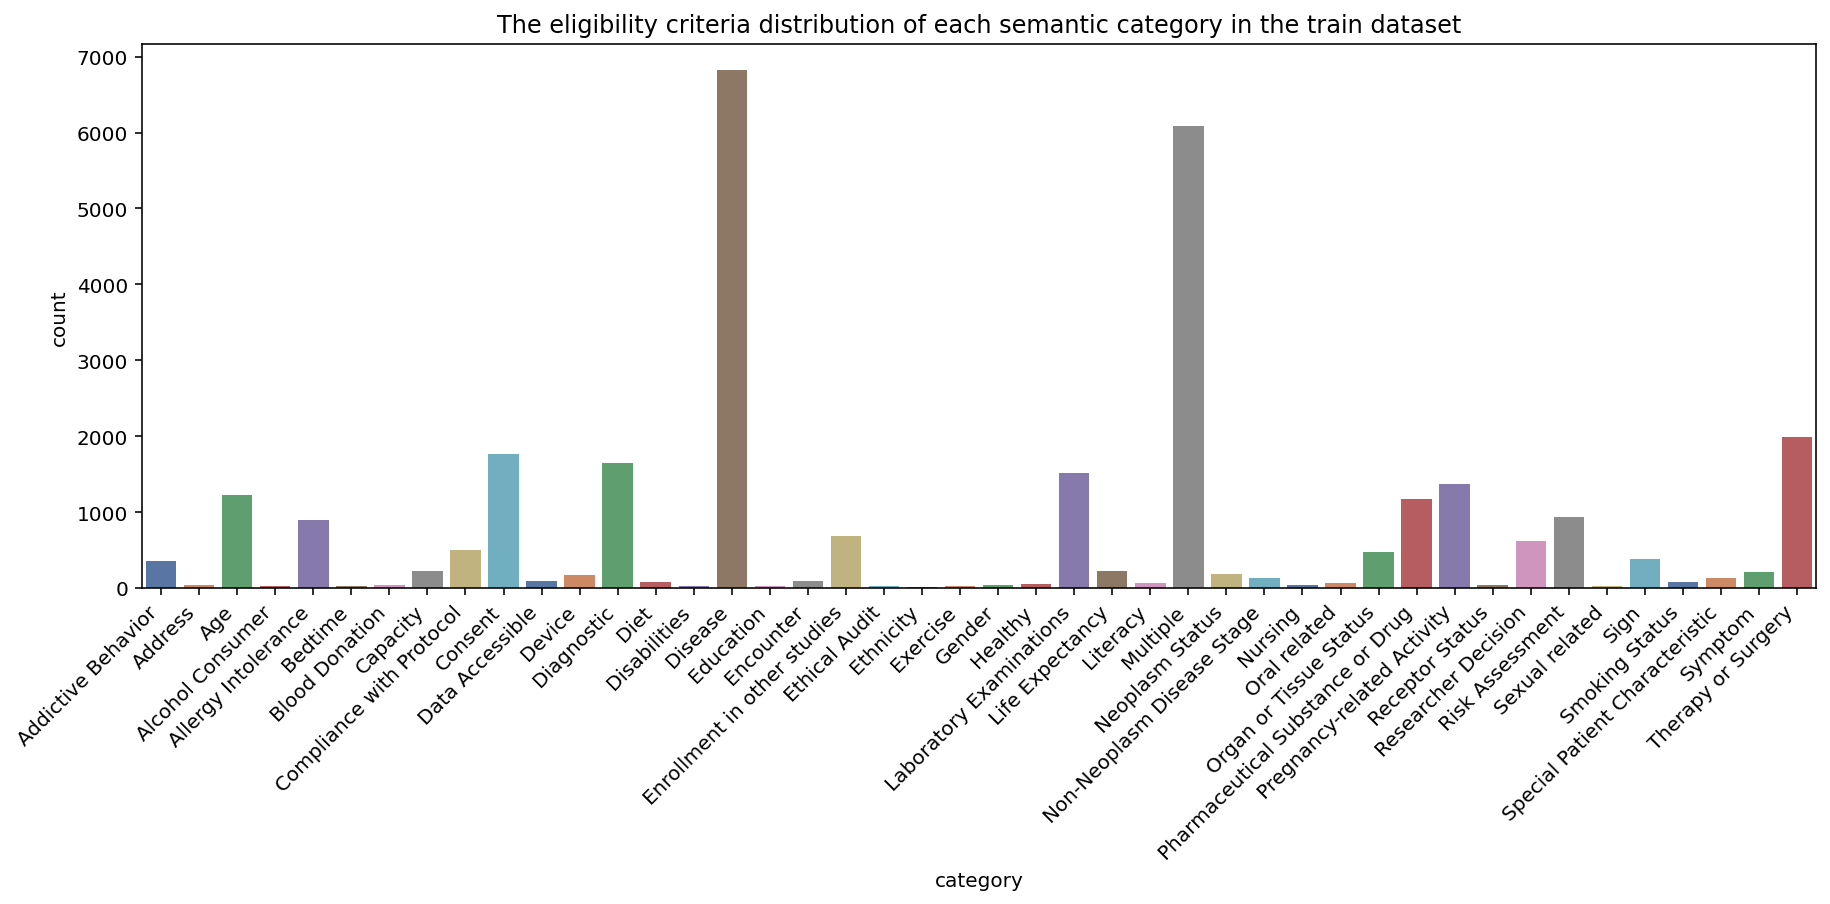

In [5]:
category_count = train_data.groupby(['category'], as_index=False)['category'].agg({'count': 'count'})
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.barplot(x=category_count["category"], y=category_count["count"], palette="deep", ax=ax)
_ = ax.set_xticklabels(labels=category_count["category"], rotation=45, ha='right')
ax.set_title("The eligibility criteria distribution of each semantic category in the train dataset")
print(category_count)

### test data

In [6]:
test_file = "../data/test.txt" 
test_data = pd.read_csv(test_file, sep="\t", header=None, names=["id", "category", "sentence"])

In [7]:
print("test data size：{}".format(len(test_data)))
print("test dara example：")
test_data.head(5)

test data size：7697
test dara example：


,id,category,sentence
0,s1,Multiple,2）性别不限，年龄18～70岁；
1,s2,Multiple,（1）以原发性胃癌为诊断入院，年龄在18岁至70岁之间的患者；
2,s3,Disease,（6）合并造血系统或恶性肿瘤等严重原发性疾病；
3,s4,Researcher Decision,-其他研究者认为不适合参加本研究的患者
4,s5,Capacity,3、儿童家长能回答或看懂研究用量表者。


categories and counts

                            category  count
0                 Addictive Behavior     88
1                            Address     12
2                                Age    305
3                   Alcohol Consumer      6
4                Allergy Intolerance    223
5                            Bedtime     12
6                     Blood Donation     11
7                           Capacity     56
8           Compliance with Protocol    120
9                            Consent    433
10                   Data Accessible     25
11                            Device     46
12                        Diagnostic    417
13                              Diet     23
14                      Disabilities      7
15                           Disease   1698
16                         Education      7
17                         Encounter     25
18       Enrollment in other studies    174
19                     Ethical Audit     11
20                         Ethnicity      5
21                          Exer

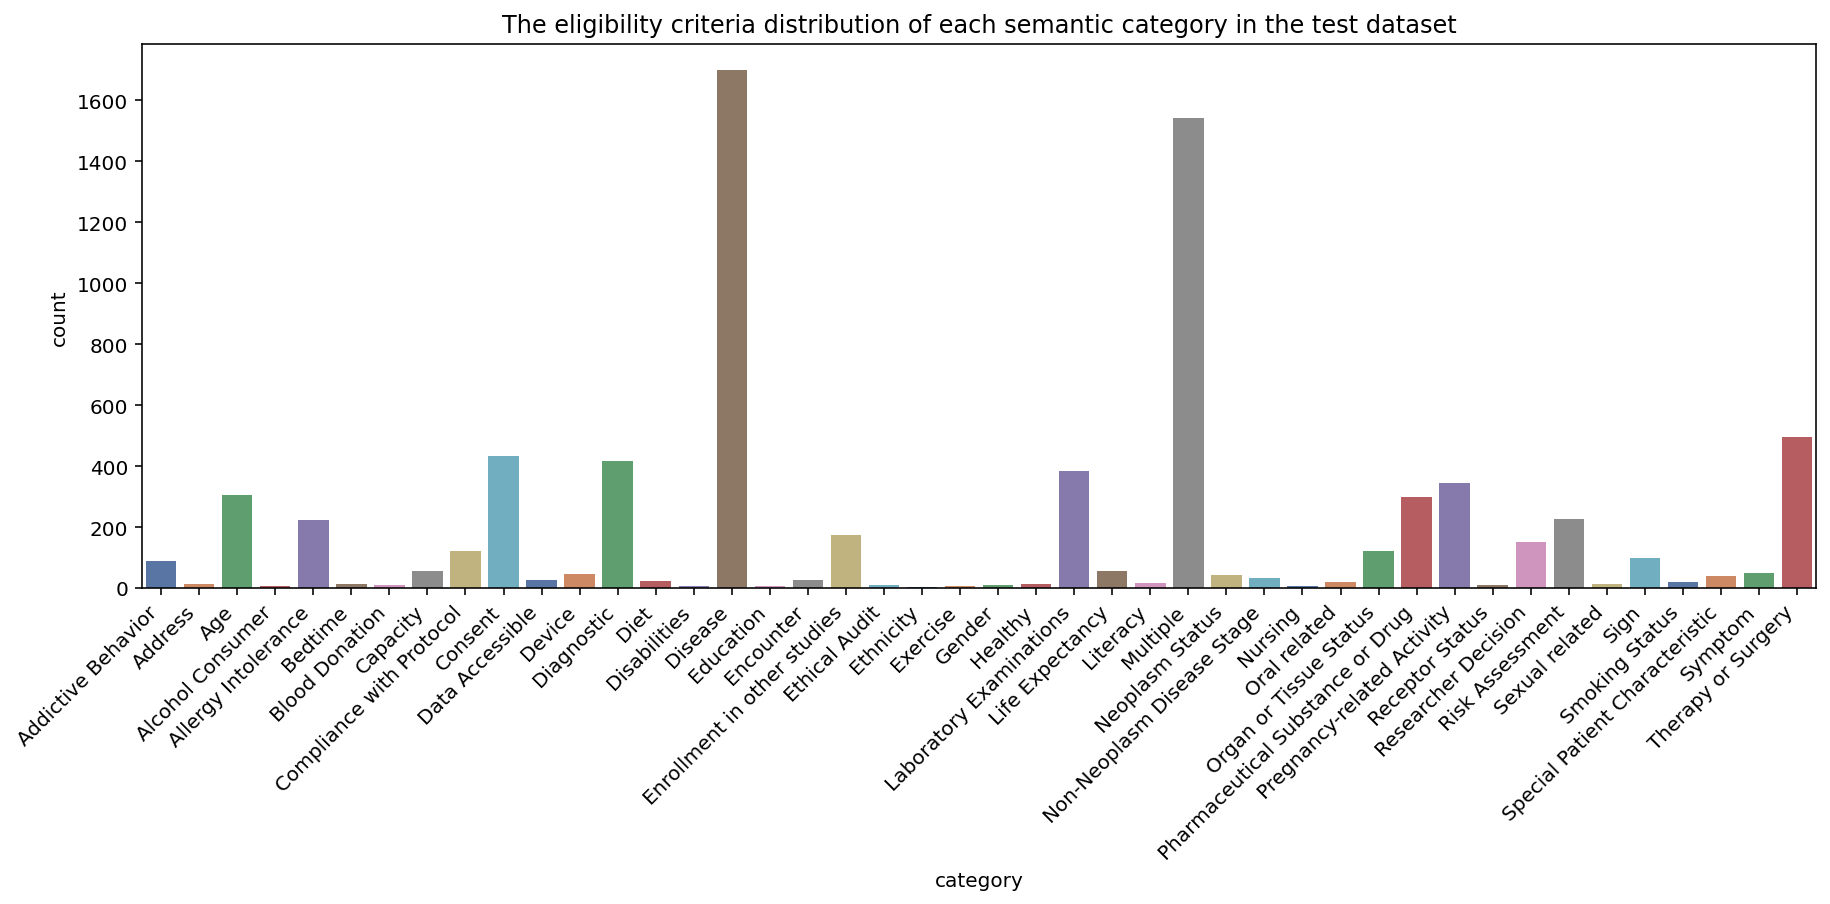

In [8]:
category_count = test_data.groupby(['category'], as_index=False)['category'].agg({'count': 'count'})
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.barplot(x=category_count["category"], y=category_count["count"], palette="deep", ax=ax)
_ = ax.set_xticklabels(labels=category_count["category"], rotation=45, ha='right')
ax.set_title("The eligibility criteria distribution of each semantic category in the test dataset")
print(category_count)

## Data Preprocessing

### BertTokenizer

**load a pre-trained BertTokenizer**

In [9]:
proxies = {"https": 'http://165.225.96.34:10015', "http":'http://165.225.96.34:10015'}
# proxies = {"https": None, "http": None}
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, proxies=proxies)

**convert the text to tokens and tokens to unique integers (ids)**

In [10]:
sample_txt = '术前有内分泌、免疫、神经及精神系统疾病'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 术前有内分泌、免疫、神经及精神系统疾病
   Tokens: ['术', '前', '有', '内', '分', '泌', '、', '免', '疫', '、', '神', '经', '及', '精', '神', '系', '统', '疾', '病']
Token IDs: [3318, 1184, 3300, 1079, 1146, 3789, 510, 1048, 4554, 510, 4868, 5307, 1350, 5125, 4868, 5143, 5320, 4565, 4567]


**special tokens**

In [11]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


**using the encode_plus() method**

In [12]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
print(encoding['input_ids'].shape)
encoding['input_ids']

torch.Size([1, 32])


tensor([[ 101, 3318, 1184, 3300, 1079, 1146, 3789,  510, 1048, 4554,  510, 4868,
         5307, 1350, 5125, 4868, 5143, 5320, 4565, 4567,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [14]:
print(encoding['attention_mask'].shape)
encoding['attention_mask']

torch.Size([1, 32])


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '术',
 '前',
 '有',
 '内',
 '分',
 '泌',
 '、',
 '免',
 '疫',
 '、',
 '神',
 '经',
 '及',
 '精',
 '神',
 '系',
 '统',
 '疾',
 '病',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### choosing max sequence length

In [16]:
token_lens = []
for s in list(train_data["sentence"])+list(test_data["sentence"]):
    tokens = tokenizer.encode(s, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token length')

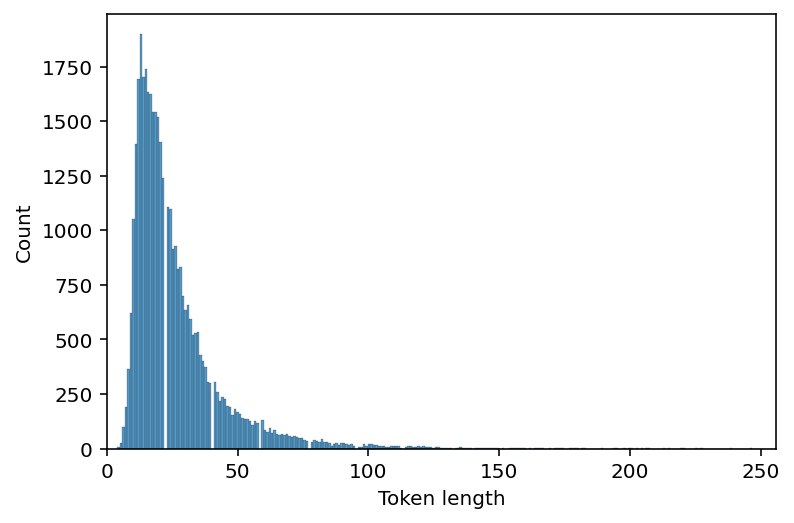

In [17]:
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token length')

In [18]:
print(len([i for i in token_lens if i<50]) / len(token_lens))

0.9109308573067995


Most of the criterion seem to contain less than 50 tokens

In [19]:
MAX_LEN = 50

## Data Loader

**create Criterion Dataset**

In [20]:
class CriterionDataset(Dataset):
    def __init__(self, criterion, targets, tokenizer, max_len):
        self.criterion = criterion
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.criterion)

    def __getitem__(self, item):
        criteria = str(self.criterion[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            criteria,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',)
    
        return {
            'criteria': criteria,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)}

In [21]:
print(train_data.shape)
print(test_data.shape)

(30644, 3)
(7697, 3)


**convert labels to index, index to labels**

In [22]:
labels = ["Disease","Symptom","Sign","Pregnancy-related Activity","Neoplasm Status","Non-Neoplasm Disease Stage",
        "Allergy Intolerance","Organ or Tissue Status","Life Expectancy","Oral related",
        "Pharmaceutical Substance or Drug","Therapy or Surgery","Device","Nursing","Diagnostic",
        "Laboratory Examinations","Risk Assessment","Receptor Status","Age","Special Patient Characteristic",
        "Literacy","Gender","Education","Address","Ethnicity","Consent","Enrollment in other studies",
        "Researcher Decision","Capacity","Ethical Audit","Compliance with Protocol","Addictive Behavior",
        "Bedtime","Exercise","Diet","Alcohol Consumer","Sexual related","Smoking Status","Blood Donation",
        "Encounter","Disabilities","Healthy","Data Accessible","Multiple"]
label2index = dict()
index2label = dict()
for (i, label) in enumerate(labels):
    label2index[label] = i
    index2label[i] = label

**create data loader**

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CriterionDataset(
        criterion=df.sentence.to_numpy(),
        targets=df.category.apply(lambda x: label2index.get(x)).to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [24]:
MAX_LEN = 50
BATCH_SIZE = 128
train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
example_batch = next(iter(train_data_loader))
example_batch.keys()

dict_keys(['criteria', 'input_ids', 'attention_mask', 'targets'])

In [26]:
print(len(example_batch['criteria']), example_batch['criteria'][0])
print(example_batch['input_ids'].shape)
print(example_batch['attention_mask'].shape)
print(example_batch['targets'].shape)

128  研究开始前30天内，接受过其他临床方案治疗；
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


## Bert Model

classification with bert and hugging face

### load model

In [27]:
proxies = {"https": 'http://165.225.96.34:10015', "http":'http://165.225.96.34:10015'}
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, proxies=proxies)

use it on the encoding of our sample text

In [28]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'],attention_mask=encoding['attention_mask'], return_dict=False)

In [29]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [30]:
pooled_output.shape

torch.Size([1, 768])

In [31]:
bert_model.config.hidden_size

768

### bert classifier

In [32]:
class CriterionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(CriterionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask, 
            return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

In [33]:
model = CriterionClassifier(len(labels))
model = model.to(device)

**moving example batch of our training data to the GPU**

In [34]:
input_ids = example_batch['input_ids'].to(device)
attention_mask = example_batch['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([128, 50])
torch.Size([128, 50])


**apply the softmax function to the outputs, get the predicted probabilities from our trained model**

In [35]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0591, 0.0124, 0.0146,  ..., 0.0153, 0.0091, 0.0274],
        [0.0351, 0.0214, 0.0208,  ..., 0.0114, 0.0115, 0.0606],
        [0.0214, 0.0134, 0.0205,  ..., 0.0108, 0.0075, 0.0555],
        ...,
        [0.0412, 0.0162, 0.0156,  ..., 0.0086, 0.0199, 0.0489],
        [0.0129, 0.0102, 0.0081,  ..., 0.0106, 0.0057, 0.0265],
        [0.0723, 0.0146, 0.0146,  ..., 0.0070, 0.0144, 0.0675]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

**epoch**

In [36]:
EPOCHS = 10

**optimizer and loss**

In [37]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
print(total_steps)

2400


**train epoch**

In [38]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

**evaluate the model on test data loader**

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

**training loop, training history**

In [40]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train_data))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(test_data))
    print(f'Test  loss {test_loss} accuracy {test_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = test_acc

Epoch 1/10
----------
Train loss 0.9201603447397549 accuracy 0.7558086411695601
Test  loss 0.6331269521205152 accuracy 0.8260361179680394

Epoch 2/10
----------
Train loss 0.4405761574705442 accuracy 0.8691097767915417
Test  loss 0.5565167098748879 accuracy 0.845524230219566

Epoch 3/10
----------
Train loss 0.3065203486941755 accuracy 0.9095744680851064
Test  loss 0.5626537482269475 accuracy 0.844744705729505

Epoch 4/10
----------
Train loss 0.22052287999540568 accuracy 0.9363333768437542
Test  loss 0.6074447758862229 accuracy 0.8437053397427569

Epoch 5/10
----------
Train loss 0.16810242403298617 accuracy 0.9522908236522648
Test  loss 0.6251276565379784 accuracy 0.8448746264778485

Epoch 6/10
----------
Train loss 0.12996006528070816 accuracy 0.9650176217204021
Test  loss 0.6675686474706306 accuracy 0.8421462907626348

Epoch 7/10
----------
Train loss 0.10154644038993865 accuracy 0.9735347865813864
Test  loss 0.7091658349897041 accuracy 0.8412368455242302

Epoch 8/10
----------
Tra

**plot loss**

(0.0, 1.0)

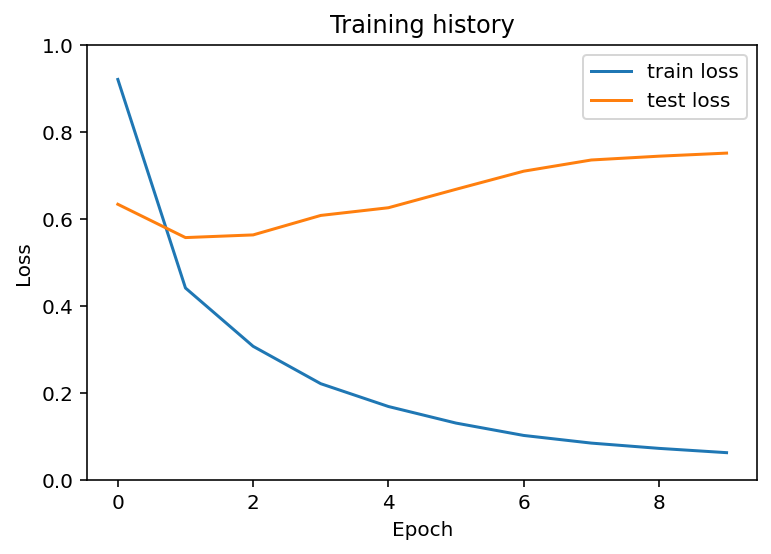

In [41]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='test loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

**plot accuracy**

(0.0, 1.0)

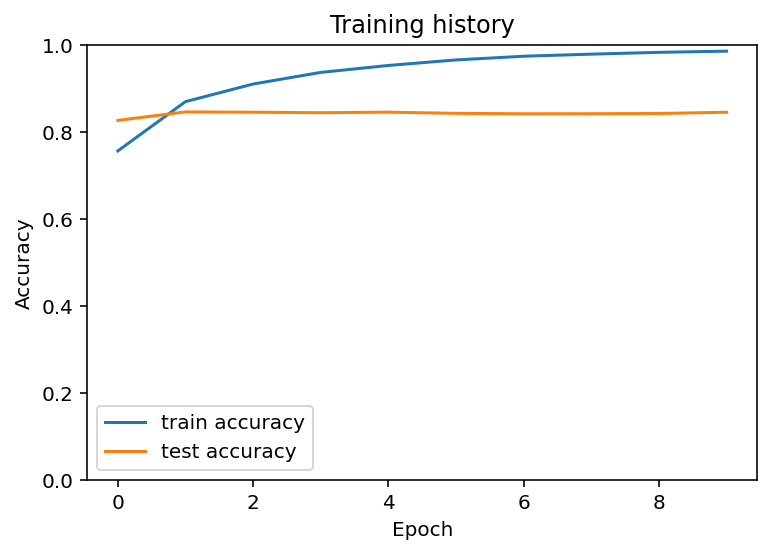

In [42]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## Evaluation

**get prediction of test data**

In [45]:
def get_predictions(model, data_loader):
    model = model.eval()
    criterion = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            criteria = d["criteria"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            criterion.extend(criteria)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return criterion, predictions, prediction_probs, real_values

In [46]:
y_criterion, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

**classification report**

In [47]:
print(classification_report(y_test, y_pred, target_names=labels))

                                  precision    recall  f1-score   support

                         Disease       0.89      0.87      0.88      1698
                         Symptom       0.60      0.54      0.57        50
                            Sign       0.45      0.45      0.45        97
      Pregnancy-related Activity       0.96      0.96      0.96       344
                 Neoplasm Status       0.56      0.64      0.60        44
      Non-Neoplasm Disease Stage       0.54      0.47      0.50        32
             Allergy Intolerance       0.95      0.95      0.95       223
          Organ or Tissue Status       0.80      0.84      0.82       120
                 Life Expectancy       0.96      0.96      0.96        55
                    Oral related       0.82      0.95      0.88        19
Pharmaceutical Substance or Drug       0.87      0.90      0.89       300
              Therapy or Surgery       0.81      0.83      0.82       496
                          Device     

**confusion matrix**

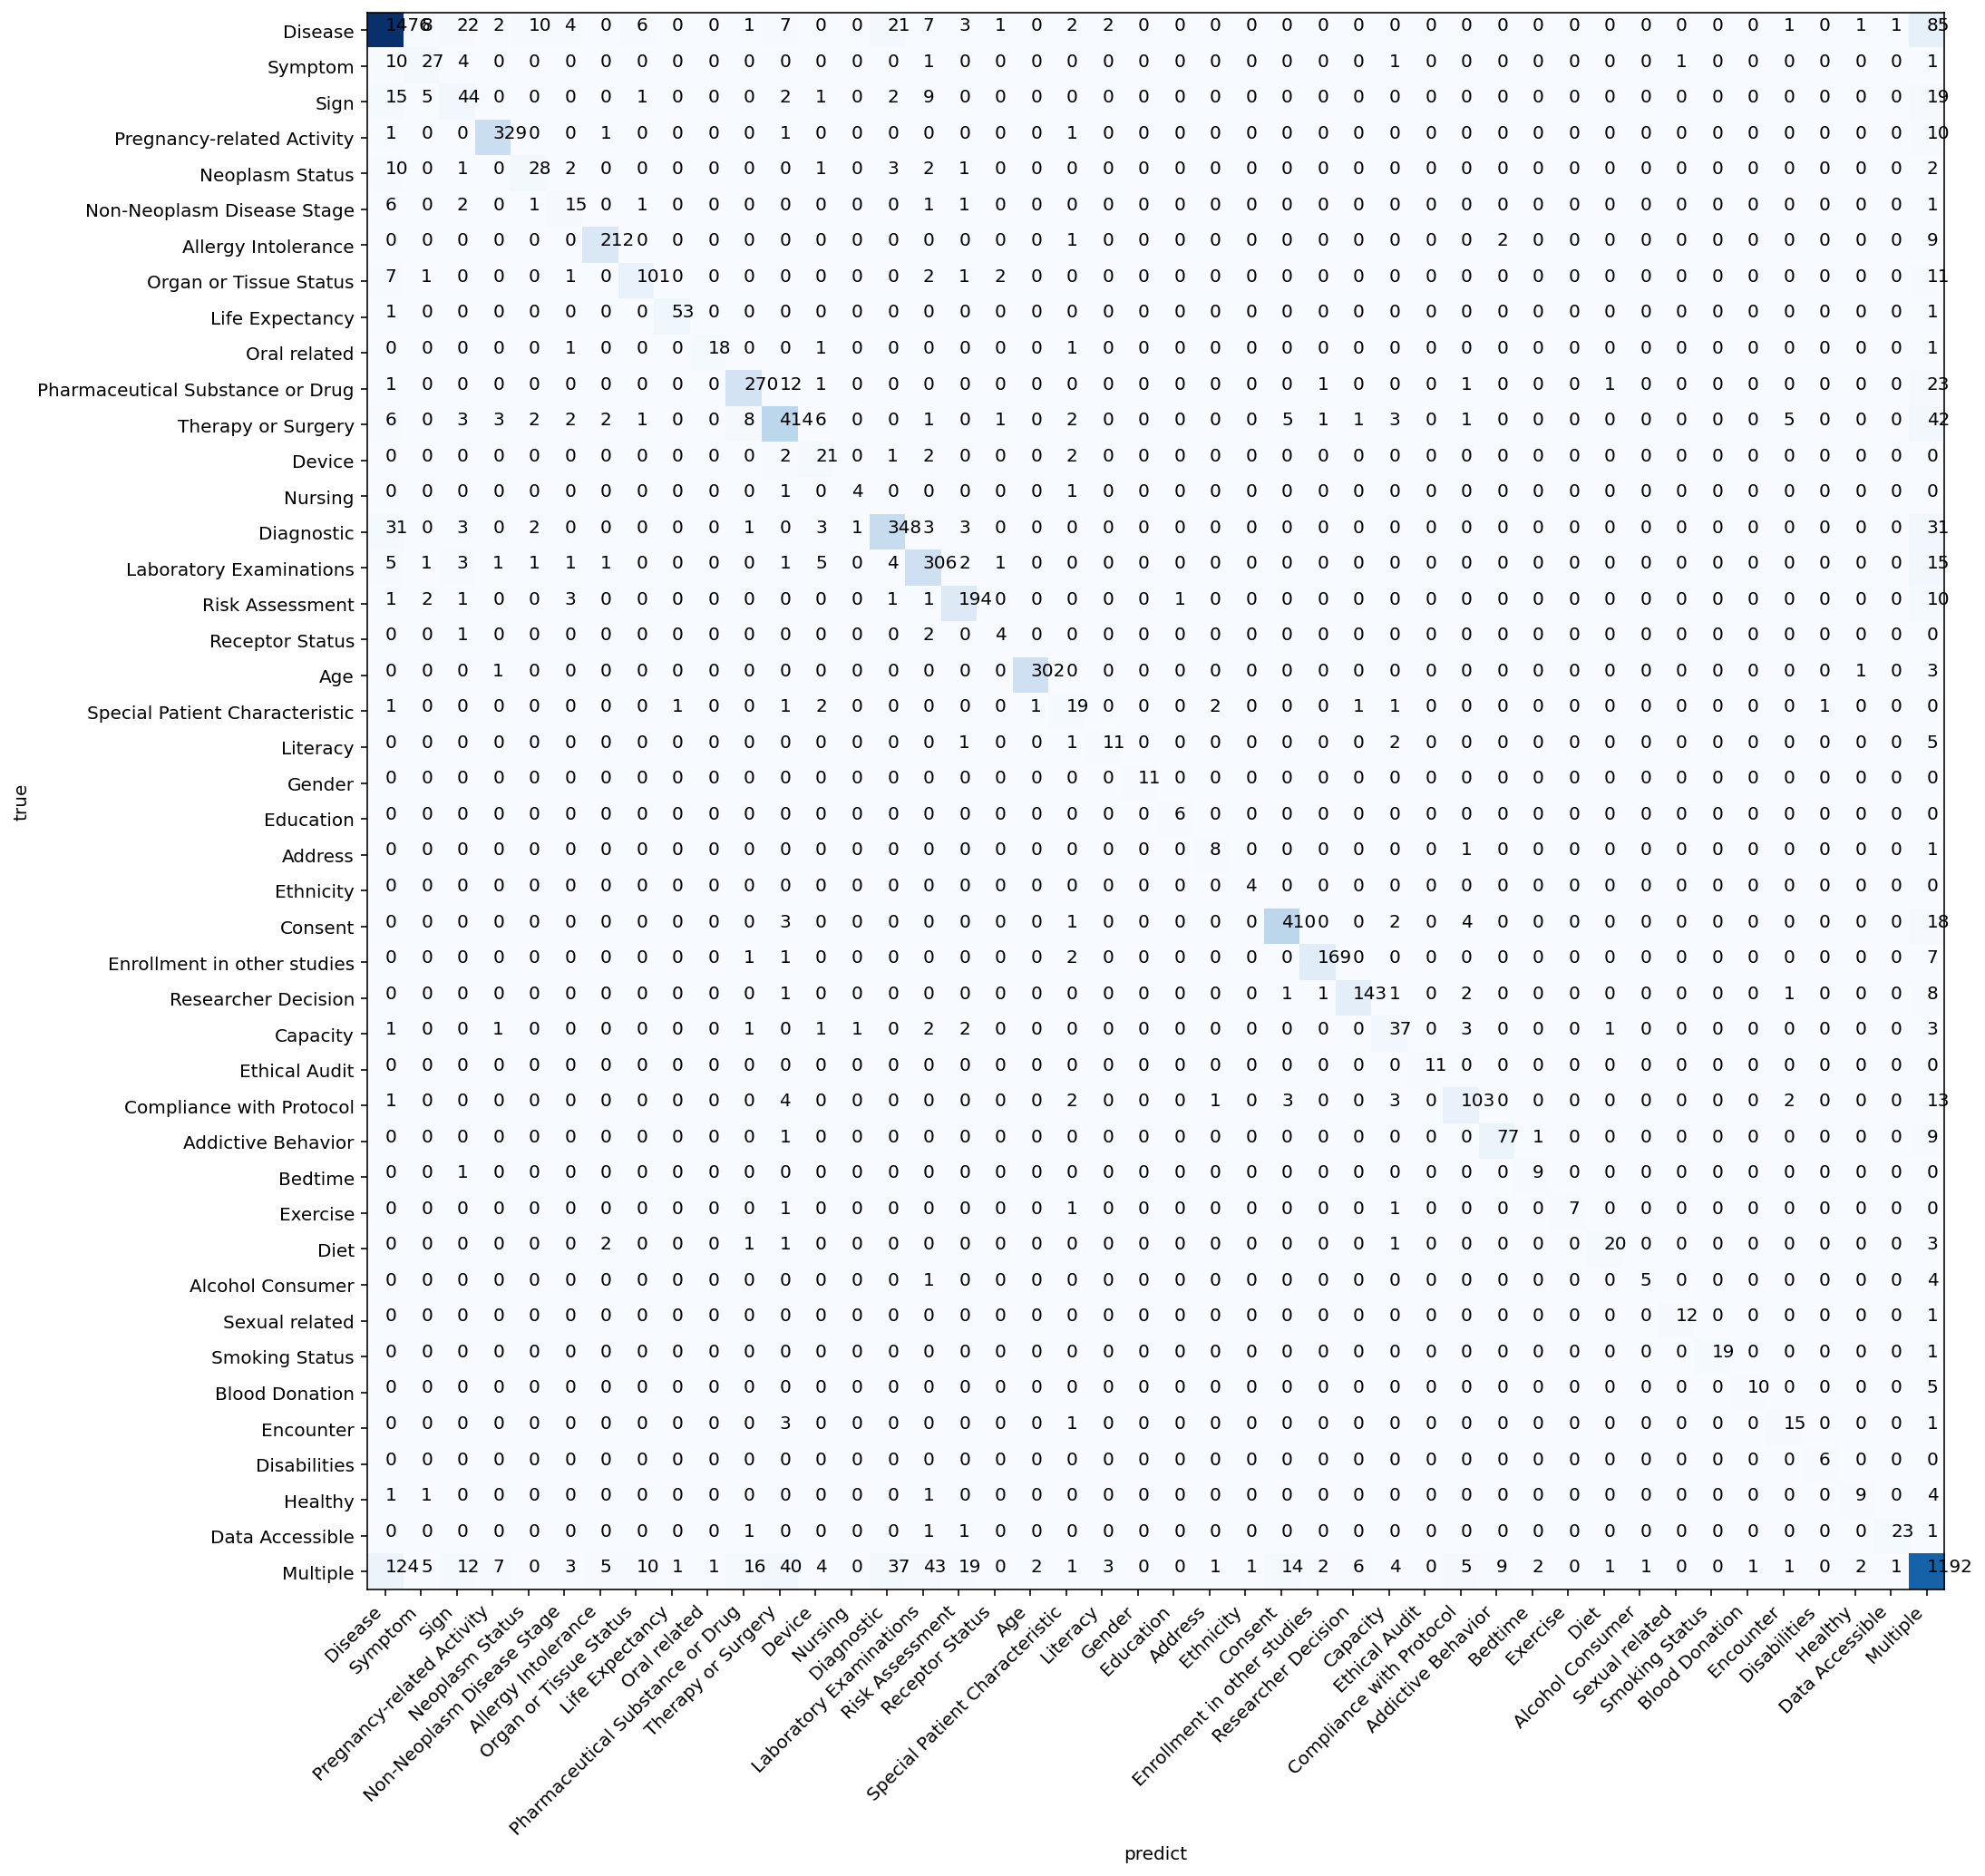

In [48]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, labels, rotation=45, ha='right')
plt.yticks(indices, labels)
# plt.colorbar()
plt.xlabel('predict')
plt.ylabel('true')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

**save predict results**

In [49]:
import codecs
with codecs.open("BERT_test_pred.txt", "w", encoding="utf-8") as outf:
    for (i, c, s) in zip(test_data["id"], y_pred.tolist(), test_data["sentence"]):
        outf.write("{}\t{}\t{}\r\n".format(i, index2label.get(c), s))

**precision, recall, F1 score**

In [50]:
import evaluation # our defined evaluation metrics.
results = evaluation.Record_results('../data/test.txt', 'Bert_test_pred.txt')
evaluation = evaluation.Evaluation(results.records)

**************************************** Evaluation results*****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.8750           0.8750           0.8750         
                            Address    0.8000           0.6667           0.7273         
                                Age    0.9837           0.9902           0.9869         
                   Alcohol Consumer    0.5000           0.8333           0.6250         
                Allergy Intolerance    0.9464           0.9507           0.9485         
                            Bedtime    0.9000           0.7500           0.8182         
                     Blood Donation    0.6667           0.9091           0.7692         
                           Capacity    0.6981           0.6607           0.6789         
           Compliance with Protocol    0.7803           0.8583           0.8175         
         

## References
* https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/